# Loan Club: Machine Learning Capstone Notebook

In [1]:
# Load packages
import pandas as pd
import numpy as np
import re
from time import strptime  # format data columns
import warnings
import math

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import seaborn as sns
import plotly.express as px

warnings.filterwarnings("ignore")  # ignore warnings throughout notebook
pd.set_option("display.max_columns", None)  # show all columns

In [2]:
# Load Data
filepath = "../data/accepted_subsampled_5percent.csv" #will be personalized
df = pd.read_csv(filepath, sep=",")

df_cleaned = df.copy() #work from second copy

In [3]:
# Features known to investors based on LC website
known_vars = ['acc_now_delinq',             # accounts now deliquent
              'collections_12_mths_ex_med', # collections excluding medical
              'fico_range_high',            # credit score range
              'fico_range_low',             # creit score range
              'delinq_2yrs',                # delinquencies in last two years
              'delinq_amnt',                # delinquency amount
              'earliest_cr_line',           # earliest credit line
              'home_ownership',             # home ownership
              'dti',                        # debt2income ratio
              'annual_inc',                 # annual income
              'initial_list_status',        # initial listing status
              'inq_last_6mths',             # credit inquires in last 6mo
              'int_rate',                   # interest rate
              'verification_status_joint',  # is this a joint app
              'emp_length',                 # length of employment (yr)
              'loan_amnt',                  # loan amount
              'id',                         # loan id
              'purpose',                    # purpose of the loan
              'term',                       # loan term (3 or 5yr)
              'addr_state',                 # borrower location state
              'installment',                # montly payment
              'mths_since_last_delinq',     # mo since last delinquency
              'mths_since_last_major_derog',# mo since last maj. derogatory
              'mths_since_last_record',     # mo since last public record
              'open_acc',                   # open credit line
              'pub_rec',                    # public records on file
              'revol_util',                 # revolving balance utilization (%)
              'revol_bal',                  # revolving credit balance ($)
              'tot_coll_amt',               # total collection amount ever
              'total_acc',                  # total credit lines
              'tot_cur_bal',                # total current balance
              'verification_status',        # verified income (Y/N I think)
              'grade'                       # loan grade
             ]

# Sanity check, print variable if not found within original dataframe
# [ print(var) for var in known_vars if (var not in df.columns)]


### Impute Missing Data of Known Variables

In [4]:
#Assess missingness of known variables
missingness = df_cleaned[known_vars].isnull().mean().T
missingness = missingness.loc[missingness>0].sort_values(ascending=False)
missingness


verification_status_joint      0.949313
mths_since_last_record         0.838543
mths_since_last_major_derog    0.744395
mths_since_last_delinq         0.513786
emp_length                     0.063868
tot_cur_bal                    0.033430
tot_coll_amt                   0.033430
revol_util                     0.001006
dti                            0.000829
collections_12_mths_ex_med     0.000476
open_acc                       0.000185
pub_rec                        0.000185
total_acc                      0.000185
inq_last_6mths                 0.000185
earliest_cr_line               0.000185
delinq_amnt                    0.000185
delinq_2yrs                    0.000185
acc_now_delinq                 0.000185
dtype: float64

In [5]:
# Drop features missing > 50% 
feat_wManyMissing = missingness.index[np.where(missingness > .5)].to_list()
df_cleaned[known_vars].drop(df_cleaned[feat_wManyMissing], axis=1, inplace=True)
[known_vars.remove(var) for var in feat_wManyMissing] #remove features from known_var list


[None, None, None, None]

In [6]:
# Replace NA's of numeric 'known_var' features with mean value
numeric_var = ['tot_cur_bal',
               'tot_coll_amt',
               'revol_util',
               'collections_12_mths_ex_med',
               'open_acc',
               'pub_rec',
               'total_acc',
               'inq_last_6mths',
               'delinq_amnt',
               'delinq_2yrs',
               'dti' ]

# List comprehension through numerica variables
[df_cleaned[var].fillna(df[var].mean(), inplace=True) for var in numeric_var]


[None, None, None, None, None, None, None, None, None, None, None]

In [7]:
# Helper function to replace missing character strings with randomly selected value
def fillna_random(var):
    #find index of missing values
    miss_idx = df_cleaned.loc[ df_cleaned[var].isnull()].index.tolist()
    
    #find new values to replace NaN values
    new_val = df_cleaned[var].loc[~df_cleaned.index.isin(miss_idx)].sample(len(miss_idx)).values.tolist()

    #replace values
    df_cleaned[var][miss_idx] = new_val

# ==================================================
# Replace NA's of character 'known_var' features with random
non_numeric_var = ['emp_length', 'earliest_cr_line', 'acc_now_delinq', 'delinq_2yrs'] #list of non-numeric variables
[fillna_random(var) for var in non_numeric_var]


[None, None, None, None]

In [8]:
#Sanity check that no more missing values
df_cleaned[known_vars].isnull().sum()


acc_now_delinq                0
collections_12_mths_ex_med    0
fico_range_high               0
fico_range_low                0
delinq_2yrs                   0
delinq_amnt                   0
earliest_cr_line              0
home_ownership                0
dti                           0
annual_inc                    0
initial_list_status           0
inq_last_6mths                0
int_rate                      0
emp_length                    0
loan_amnt                     0
id                            0
purpose                       0
term                          0
addr_state                    0
installment                   0
open_acc                      0
pub_rec                       0
revol_util                    0
revol_bal                     0
tot_coll_amt                  0
total_acc                     0
tot_cur_bal                   0
verification_status           0
grade                         0
dtype: int64

### Feature Engineering

In [9]:
# Simplify loan status (non-FullyPaid or ChargedOff loans will be converted to NAN)
df_cleaned['loan_status'] = df_cleaned['loan_status'].map({'Fully Paid':'Fully Paid',
                                                           'Charged Off':'Charged Off',
                                                           'Does not meet the credit policy. Status:Fully Paid': 'Fully Paid',
                                                           'Does not meet the credit policy. Status:Charged Off': 'Charged Off'})

# Remove non-completed loans
df_cleaned.drop(df_cleaned.loc[df_cleaned['loan_status'].isnull()].index.tolist(), axis=0, inplace=True)

# Simplify home ownership
df_cleaned['home_ownership'] = df_cleaned['home_ownership'].map({'MORTGAGE':'mortgage',
                                                                 'OWN':'own',
                                                                 'RENT':'rent'})

# Remove 25 observations without houses
df_cleaned.drop(df_cleaned.loc[df_cleaned['home_ownership'].isnull()].index.tolist(), axis=0, inplace=True)


# Reformat date features and calculate features related to prepayment  
df_cleaned['term_year'] = np.where(df_cleaned['term']==' 36 months', 3,5)
df_cleaned['earliest_cr_line'] =  pd.to_datetime(df_cleaned['earliest_cr_line'])
df_cleaned['issue_date'] =  pd.to_datetime(df_cleaned['issue_d'])
df_cleaned['last_pymnt_date'] = pd.to_datetime(df_cleaned['last_pymnt_d'])
df_cleaned['exp_last_pymnt_date'] = pd.to_datetime(df_cleaned['issue_d'].str[0:3]
                                                   +'-'
                                                   + (df_cleaned['issue_d'].str[-4:].astype('int')
                                                   + df_cleaned['term_year']).astype('str'))

# Calculate credit history ( in months )
date_ofloan = df_cleaned['issue_date'].dt.to_period('M').astype(int)
date_credline = df_cleaned['earliest_cr_line'].dt.to_period('M').astype(int)
df_cleaned['credit_hist_mths'] = date_ofloan - date_credline
df_cleaned['credit_hist_mths'] = np.where(df_cleaned['credit_hist_mths'] < 0, 0, df_cleaned['credit_hist_mths'])

# Log-transform skewed continuous features
df_cleaned['delinq_amnt_log'] = df_cleaned['delinq_amnt'].add(1).apply(np.log)
df_cleaned['annual_inc_log'] = df_cleaned['annual_inc'].add(1).apply(np.log)
df_cleaned['dti_log'] = df_cleaned['dti'].add(1).apply(np.log)
df_cleaned['funded_amnt_log'] = df_cleaned['funded_amnt'].add(1).apply(np.log)
df_cleaned['tot_coll_amt_log'] = df_cleaned['tot_coll_amt'].add(1).apply(np.log)
df_cleaned['tot_cur_bal_log'] = df_cleaned['tot_cur_bal'].add(1).apply(np.log)
df_cleaned['total_acc_log'] = df_cleaned['total_acc'].add(1).apply(np.log)
df_cleaned['revol_bal_log'] = df_cleaned['revol_bal'].add(1).apply(np.log)
df_cleaned['installment_log'] = df_cleaned['installment'].add(1).apply(np.log)
df_cleaned['open_acc_log'] = df_cleaned['open_acc'].add(1).apply(np.log)

# Simplify loan purpose - debt consolidation, credit card, and other
df_cleaned['purpose'] = df_cleaned['purpose'].map({'debt_consolidation':'debt_consolidation',
                                                   'credit_card':'credit_card'})
df_cleaned['purpose'].fillna('other',inplace=True)

# Convert loan grade to ordinal feature
df_cleaned['grade'] = df_cleaned['grade'].map({'A':1,
                                               'B':2,
                                               'C':3,
                                               'D':4,
                                               'E':5,
                                               'F':6,
                                               'G':7})

# Simplify employment length to four categories
df_cleaned['emp_length'] = df_cleaned['emp_length'].map({'< 1 year':0.5,
                                                         '1 year':1,
                                                         '2 years':2,
                                                         '3 years':3,
                                                         '4 years':4,
                                                         '5 years':5,
                                                         '6 years':6,
                                                         '7 years':7,
                                                         '8 years':8,
                                                         '9 years':9,
                                                         '10+ years':10})

# Create new binary features
df_cleaned['has_pub_rec'] = np.where(df_cleaned['pub_rec']>0,1,0) #0-=no public record
df_cleaned['has_paid_early'] = np.where((df_cleaned.loan_status=='Fully Paid')&(df_cleaned.last_pymnt_date < df_cleaned.exp_last_pymnt_date), 1, 0)
df_cleaned['has_36mo_loan'] = np.where(df_cleaned['term'].str.contains('36'),1,0) #0=60mo loan
df_cleaned['has_delinq_now'] = np.where(df_cleaned['acc_now_delinq']>0, 1, 0)
df_cleaned['has_delinq_past2yrs'] = np.where(df_cleaned['delinq_2yrs']>0, 1, 0) #0=no delinq within 2yrs
df_cleaned['has_whole_liststatus'] = np.where(df_cleaned['initial_list_status']=='w', 1, 0) #0=f
df_cleaned['has_fullypaid'] = np.where(df_cleaned['loan_status']=='Fully Paid', 1, 0) #0=charged off


In [10]:
# Create response variable based on 
threshold = -20 #goal % return
df_cleaned["roi_perc"] = df_cleaned["total_pymnt"].div(df_cleaned["funded_amnt"]).sub(1).mul(100)
df_cleaned['roi_response'] = np.where(df_cleaned['roi_perc'] > threshold, 1, 0)

print('Fraction of loans above threadhold: %.3f' % df_cleaned['roi_response'].mean())



Fraction of loans above threadhold: 0.838


In [11]:
# Isolate list of predictor variables to be used for ML
predictor_vars = ['annual_inc_log',
                  'credit_hist_mths',
                  'delinq_amnt_log',
                  'dti_log',
                  'emp_length',
                  'fico_range_high',
                  'funded_amnt_log',
                  'grade',
                  'has_36mo_loan',
                  'has_delinq_now',
                  'has_delinq_past2yrs',
                  'has_pub_rec',
                  'has_whole_liststatus',
                  'home_ownership',
                  'inq_last_6mths',
                  'installment_log',
                  'int_rate',
                  'open_acc_log',
                  'purpose',
                  'revol_bal_log',
                  'revol_util',
                  'tot_coll_amt_log',
                  'tot_cur_bal_log',
                  'total_acc_log',
                  'verification_status']

response_var = 'roi_response'


# Machine Learning

### Logistic Regression
- Goal is to build classifier that predicts if loan results in desirable outcome
- Should also report feature importance

In [12]:
# Dummify categorical features
home_ownership_dummy = pd.get_dummies(df_cleaned['home_ownership'],
                                      prefix="home_ownership").drop('home_ownership_mortgage',axis=1)

purpose_dummy = pd.get_dummies(df_cleaned['purpose'],
                               prefix="purpose").drop('purpose_debt_consolidation',axis=1)

verification_status_dummy = pd.get_dummies(df_cleaned['verification_status'],
                               prefix="verification_status").drop('verification_status_Source Verified',axis=1)


In [13]:
# List of numeric features in the final dataframe
numeric_vars = ['annual_inc_log',
                'credit_hist_mths',
                'delinq_amnt_log',
                'dti_log',
                'emp_length',
                'fico_range_high',
                'funded_amnt_log',
                'grade',
                'has_36mo_loan',
                'has_delinq_now',
                'has_delinq_past2yrs',
                'has_pub_rec',
                'has_whole_liststatus',
                'inq_last_6mths',
                'installment_log',
                'int_rate',
                'open_acc_log',
                'revol_bal_log',
                'revol_util',
                'tot_coll_amt_log',
                'tot_cur_bal_log',
                'total_acc_log']


In [14]:
# final dataframe for model consumption
df_feature_final = pd.concat([df_cleaned[numeric_vars],
                      home_ownership_dummy,
                      purpose_dummy,
                      verification_status_dummy],axis=1)

### Tree-Based Model
- Goal is to build classifier that predicts if loan results in desirable outcome
- Should also report feature importance

- Initially explored Random Forest algorithm but switched to XGboost due to time constraint


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
import sklearn.model_selection as ms
import xgboost as xgb
from sklearn import ensemble

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline



#### Naive XGBoost Model

In [18]:
#Create test-train split of data
x = df_feature_final
y = df_cleaned[response_var] #labels
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

#Create random forest object
randomForest = ensemble.RandomForestClassifier()

#Set random forest parameters
randomForest.set_params()

#Fit model with data
randomForest.fit(x_train, y_train)

#Calculate the train and test accuracy
train_acc = randomForest.score(x_train, y_train)
test_acc = randomForest.score(x_test, y_test)

print('The training accuracy is: %.5f' % train_acc)
print('The test accuracy is: %.5f' % test_acc)

# =====================================================================
# Train error (98.9%) is much greater than test error (58.3%)
# Due to overfit

The training accuracy is: 0.99270
The test accuracy is: 0.81462


#### Grid Search CV

Several hyperparameters to tune:
- criterion = gini impurity or information entropy
- n_estimators = number of trees in forest model
- max_depth = depth of each tree
- min_samples_split = # samples required to split a leaf node
- min_samples_leaf = # samples required to be at leaf node


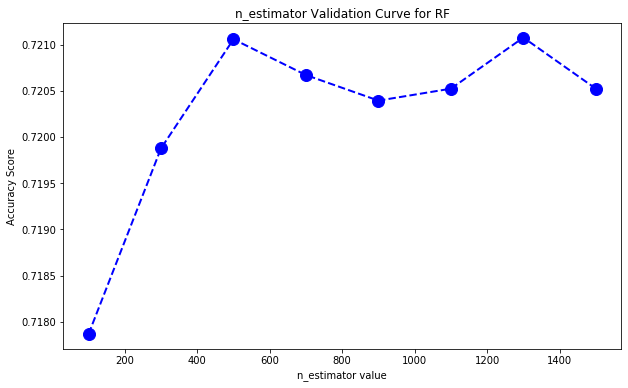

Max accuracy: 0.72108
Best parameter value: 1300.00000

CPU times: user 523 ms, sys: 240 ms, total: 763 ms
Wall time: 13min 53s


In [18]:
%%time

# Tuning n_estimator hyperparameter
num_est = range(100,1700,200)
train_scoreNum, test_scoreNum = validation_curve(randomForest,
                                                 X = x_train,
                                                 y = y_train,
                                                 param_name = 'n_estimators',
                                                 param_range = num_est, 
                                                 cv = 5,
                                                 n_jobs=-1)
#Plot
plt.figure(figsize=(10,6))
n_est_plot = plt.plot(num_est, test_scoreNum.mean(axis=1), 'bo--', linewidth=2, markersize=12)
plt.title('n_estimator Validation Curve for RF')
plt.xlabel('n_estimator value')
plt.ylabel('Accuracy Score')
plt.show(n_est_plot)

#Print best results
acc = test_scoreNum.mean(axis=1).tolist()
idx = max(range(len(acc)), key = lambda i: acc[i])
print('Max accuracy: %.5f' % acc[idx])
print('Best parameter value: %.5f\n' % num_est[idx])


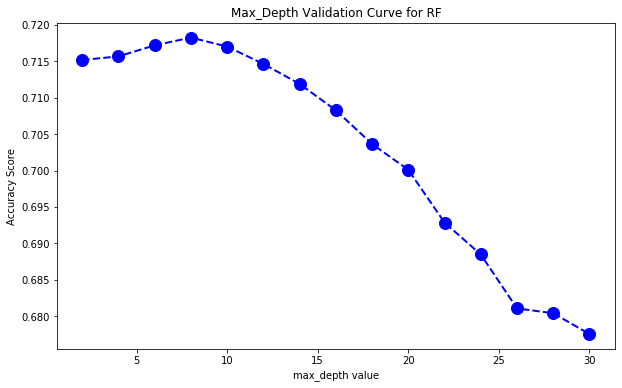

Max accuracy: 0.71824
Best parameter value: 8.00000

CPU times: user 651 ms, sys: 141 ms, total: 792 ms
Wall time: 12.9 s


In [19]:
%%time 

# Tuning max_depth hyperparameter
maxdepth_est = range(2,31,2)
train_scoreNum, test_scoreNum = validation_curve(randomForest,
                                                 X = x_train,
                                                 y = y_train,
                                                 param_name = 'max_depth',
                                                 param_range = maxdepth_est, 
                                                 cv = 5,
                                                 n_jobs=-1)
#Plot
plt.figure(figsize=(10,6))
maxdepth_plot = plt.plot(maxdepth_est, test_scoreNum.mean(axis=1), 'bo--', linewidth=2, markersize=12)
plt.title('Max_Depth Validation Curve for RF')
plt.xlabel('max_depth value')
plt.ylabel('Accuracy Score')
plt.show(maxdepth_plot)

#Print best results
acc = test_scoreNum.mean(axis=1).tolist()
idx = max(range(len(acc)), key = lambda i: acc[i])
print('Max accuracy: %.5f' % acc[idx])
print('Best parameter value: %.5f\n' % maxdepth_est[idx])


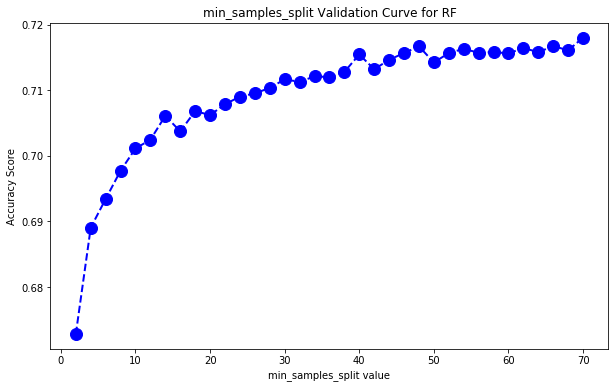

Max accuracy: 0.71803
Best parameter value: 70.00000

CPU times: user 1.24 s, sys: 326 ms, total: 1.57 s
Wall time: 38 s


In [20]:
%%time 

# Tuning min_samples_split hyperparameter
min_samples_split_est = range(2,71,2)
train_scoreNum, test_scoreNum = validation_curve(randomForest,
                                                 X = x_train,
                                                 y = y_train,
                                                 param_name = 'min_samples_split',
                                                 param_range = min_samples_split_est, 
                                                 cv = 5,
                                                 n_jobs=-1)
#Plot
plt.figure(figsize=(10,6))
min_samples_split_plot = plt.plot(min_samples_split_est, test_scoreNum.mean(axis=1), 'bo--', linewidth=2, markersize=12)
plt.title('min_samples_split Validation Curve for RF')
plt.xlabel('min_samples_split value')
plt.ylabel('Accuracy Score')
plt.show(min_samples_split_plot)

#Print best results
acc = test_scoreNum.mean(axis=1).tolist()
idx = max(range(len(acc)), key = lambda i: acc[i])
print('Max accuracy: %.5f' % acc[idx])
print('Best parameter value: %.5f\n' % min_samples_split_est[idx])


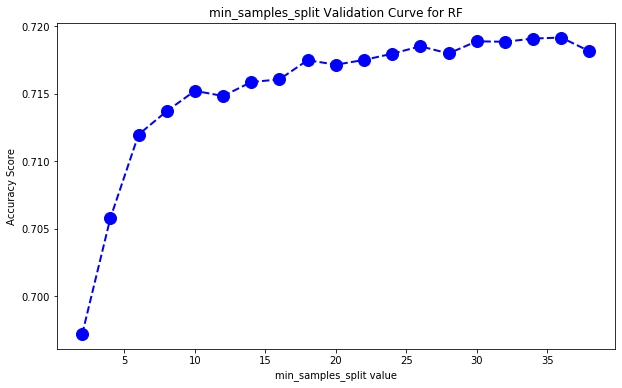

Max accuracy: 0.71918
Best parameter value: 36.00000

CPU times: user 769 ms, sys: 193 ms, total: 961 ms
Wall time: 17.8 s


In [21]:
%%time 

# Tuning min_samples_leaf hyperparameter
min_samples_leaf_est = range(2,40,2)
train_scoreNum, test_scoreNum = validation_curve(randomForest,
                                                 X = x_train,
                                                 y = y_train,
                                                 param_name = 'min_samples_leaf',
                                                 param_range = min_samples_leaf_est, 
                                                 cv = 5,
                                                 n_jobs=-1)
#Plot
plt.figure(figsize=(10,6))
min_samples_leaf_plot = plt.plot(min_samples_leaf_est, test_scoreNum.mean(axis=1), 'bo--', linewidth=2, markersize=12)
plt.title('min_samples_split Validation Curve for RF')
plt.xlabel('min_samples_split value')
plt.ylabel('Accuracy Score')
plt.show(min_samples_leaf_plot)


#Print best results
acc = test_scoreNum.mean(axis=1).tolist()
idx = max(range(len(acc)), key = lambda i: acc[i])
print('Max accuracy: %.5f' % acc[idx])
print('Best parameter value: %.5f\n' % min_samples_leaf_est[idx])


In [ ]:
#Use grid search CV to find best parameters to prevent overfitting
grid_para_forest = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': range(700,800,100),
    'max_depth': range(2,16,2), 
    'min_samples_split': range(30, 61, 2),
    'min_samples_leaf':range(20,  51, 2)   
}

#Run RandomForest classifier through grid search
grid_search_forest = ms.GridSearchCV(randomForest, grid_para_forest, scoring='accuracy', cv=5, n_jobs=-1, verbose=True)

#Fit data to classifier
%time grid_search_forest.fit(x_train, y_train)

Fitting 5 folds for each of 3584 candidates, totalling 17920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 26.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 42.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 73.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 110.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 169.3min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 244.6min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 344.9min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 474.7min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 631.9min


#### New model with results from gridsearch

In [23]:
# #View results from grid search
# grid_search_forest.best_params_

# #What is the best score?
# grid_search_forest.best_score_ #best score
# grid_search_forest.best_estimator_ #best model

# #Determine training/testing accuracies
# train_acc = grid_search_forest.best_estimator_.score(x_train, y_train)
# test_acc = grid_search_forest.best_estimator_.score(x_test, y_test)

# print('The training accuracy is: %.5f' % train_acc)
# print('The test accuracy is: %.5f' % test_acc)


#### Feature Importance

In [24]:
# #What are the 5 most important features? 
# feature_importance = list(zip(x.columns, grid_search_forest.best_estimator_.feature_importances_))
# dtype = [('feature', 'S10'), ('importance', 'float')]
# feature_importance = np.array(feature_importance, dtype=dtype)
# feature_sort = np.sort(feature_importance, order='importance')[::-1]
# plt.barh(range(len(featureScores)), featureScores, tick_label=featureNames)
# plt.title('feature importance')


### Create Partial Dependence Plot
- Link https://towardsdatascience.com/introducing-pdpbox-2aa820afd312

### Survival Analysis

**KM Curve**

**Cox model**
- Use same predictors as random forest